In [1]:
!pip install ssspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 7.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

In [4]:
from ssspy.utils.dataset import download_sample_speech_data

In [67]:
n_sources = 2
max_duration = 10
reverb_duration = 0.16
sisec2010_tag = "dev1_female3"
n_fft, hop_length = 4096, 2048

In [68]:
waveform_src_img, sample_rate = download_sample_speech_data(
    n_sources=n_sources,
    sisec2010_tag=sisec2010_tag,
    max_duration=max_duration,
    reverb_duration=reverb_duration,
    conv=True,
)  # (n_channels, n_sources, n_samples)
waveform_mix = np.sum(waveform_src_img, axis=1)  # (n_channels, n_samples)

In [70]:
for idx, waveform in enumerate(waveform_mix):
    print("Mixture: {}".format(idx + 1))
    display(ipd.Audio(waveform, rate=sample_rate))
    print()

Mixture: 1



Mixture: 2


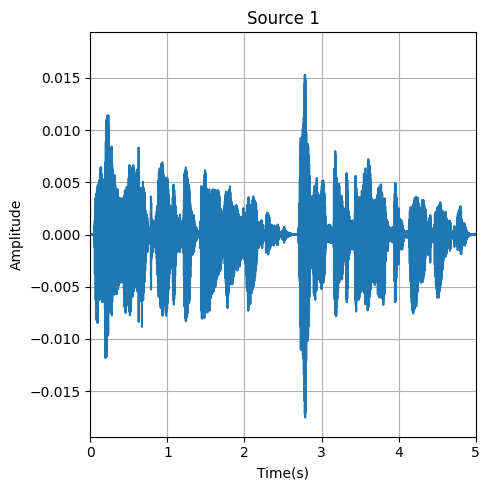

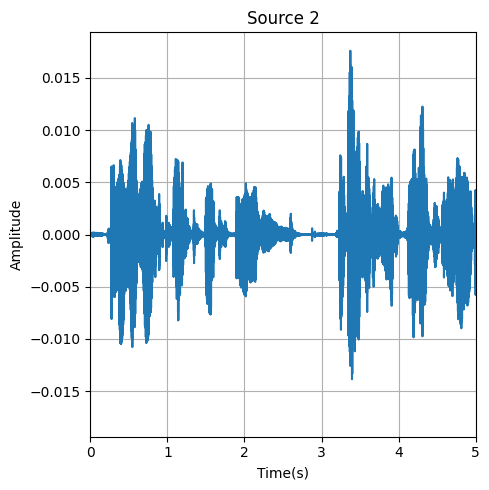

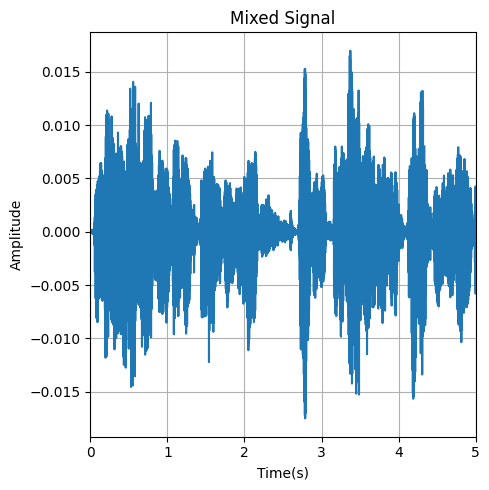

In [71]:
# Calculate time axis for 5 seconds
time = np.linspace(0, 5, int(5 * sample_rate), endpoint=False)

# Find maximum amplitude for both source signals
max_amp = max(
    np.max(np.abs(waveform_src_img[0, 0, :len(time)])),
    np.max(np.abs(waveform_src_img[0, 1, :len(time)]))
) * 1.1  # Add 10% margin

# Set common y-axis limits for both source signals
y_lim = (-max_amp, max_amp)

# Plot first clean source (first 5 seconds)
plt.figure(figsize=(5, 5))
plt.plot(time, waveform_src_img[0, 0, :len(time)])
plt.title('Source 1')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 5)
plt.ylim(y_lim)  # Apply common y-axis limits
plt.tight_layout()
plt.show()

# Plot second clean source (first 5 seconds)
plt.figure(figsize=(5, 5))
plt.plot(time, waveform_src_img[0, 1, :len(time)])
plt.title('Source 2')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 5)
plt.ylim(y_lim)  # Apply common y-axis limits
plt.tight_layout()
plt.show()

# Plot mixed signal (first 5 seconds) - with its own y-axis scale
plt.figure(figsize=(5, 5))
plt.plot(time, waveform_mix[0, :len(time)])
plt.title('Mixed Signal')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 5)
plt.tight_layout()
plt.show()

In [72]:
from ssspy.bss.mnmf import FastGaussMNMF as FastGaussMNMFBase

In [73]:
class FastGaussMNMF(FastGaussMNMFBase):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.progress_bar = None

    def __call__(self, *args, n_iter: int = 100, **kwargs):
        self.n_iter = n_iter

        return super().__call__(*args, n_iter=n_iter, **kwargs)

    def update_once(self) -> None:
        if self.progress_bar is None:
            self.progress_bar = tqdm(total=self.n_iter)

        super().update_once()

        self.progress_bar.update(1)

In [74]:
mnmf = FastGaussMNMF(
    n_basis=64,
    n_sources=2,
    diagonalizer_algorithm="IP2",  # You can set "IP" instead of "IP1".
    partitioning=False,
    rng=np.random.default_rng(42),
)
print(mnmf)

FastGaussMNMF(n_basis=64, n_sources=2, diagonalizer_algorithm=IP2, partitioning=False, record_loss=True, reference_id=0)


In [75]:
_, _, spectrogram_mix = ss.stft(waveform_mix, window="hann", nperseg=n_fft, noverlap=n_fft-hop_length)

In [77]:
spectrogram_est = mnmf(spectrogram_mix, n_iter=400)

In [78]:
_, waveform_est = ss.istft(spectrogram_est, window="hann", nperseg=n_fft, noverlap=n_fft-hop_length)

In [79]:
for idx, waveform in enumerate(waveform_est):
    print("Estimated source: {}".format(idx + 1))
    display(ipd.Audio(waveform, rate=sample_rate))
    print()

Estimated source: 1



Estimated source: 2


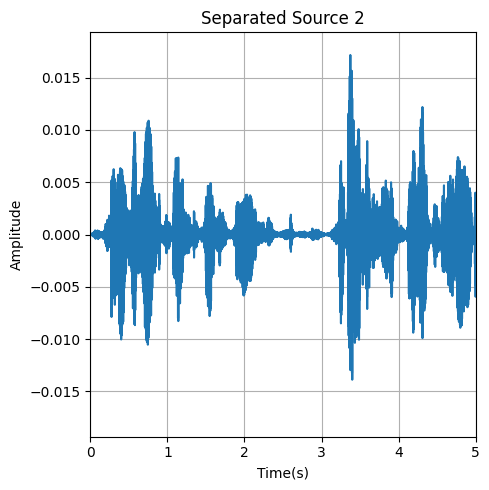

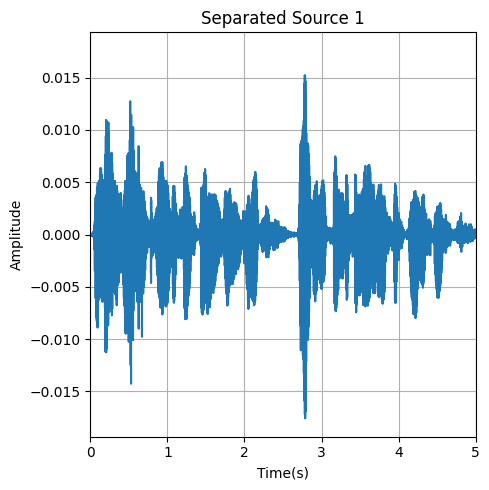

In [84]:
# Calculate time axis for 5 seconds for separated signals
time_sep = np.linspace(0, 5, int(5 * sample_rate), endpoint=False)

# Ensure we don't exceed the length of separated signals
n_samples_sep = min(len(time_sep), waveform_est.shape[1])

# Find maximum amplitude for both separated signals
max_amp_sep = max(
    np.max(np.abs(waveform_est[0, :n_samples_sep])),
    np.max(np.abs(waveform_est[1, :n_samples_sep]))
) * 1.1  # Add 10% margin

# Set common y-axis limits for separated signals
y_lim_sep = (-max_amp_sep, max_amp_sep)

# Plot first separated source (first 5 seconds)
plt.figure(figsize=(5, 5))
plt.plot(time_sep[:n_samples_sep], waveform_est[1, :n_samples_sep])
plt.title('Separated Source 2')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 5)
plt.ylim(y_lim_sep)  # Apply common y-axis limits
plt.tight_layout()
plt.show()

# Plot second separated source (first 5 seconds)
plt.figure(figsize=(5, 5))
plt.plot(time_sep[:n_samples_sep], waveform_est[0, :n_samples_sep])
plt.title('Separated Source 1')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 5)
plt.ylim(y_lim_sep)  # Apply common y-axis limits
plt.tight_layout()
plt.show()


In [81]:

import mir_eval.separation as separation

# 确保参考信号和估计信号长度一致
min_len = min(waveform_src_img.shape[2], waveform_est.shape[1])
ref_signals = waveform_src_img[0, :, :min_len]  # 参考信号 (n_sources, n_samples)
est_signals = waveform_est[:, :min_len]  # 估计信号 (n_sources, n_samples)

# 计算评估指标
sdr, sir, sar, perm = separation.bss_eval_sources(
    ref_signals,
    est_signals,
    compute_permutation=True  # 启用自动排列校正
)

# 重新排序估计信号
est_signals_aligned = est_signals[perm]

# 计算指标时使用对齐后的信号计算SNR
snr = []
for i in range(n_sources):
    noise = ref_signals[i] - est_signals_aligned[i]  # 使用对齐后的信号
    signal_power = np.mean(ref_signals[i]**2)
    noise_power = np.mean(noise**2)
    snr.append(10 * np.log10(signal_power / noise_power))

# 打印结果
print("Separation Quality Metrics:")
print("{:>10} {:>10} {:>10} {:>10} {:>10}".format(
    "Source", "SDR (dB)", "SIR (dB)", "SAR (dB)", "SNR (dB)"))
for i in range(n_sources):
    print("{:>10} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.2f}".format(
        i+1, sdr[i], sir[i], sar[i], snr[i]))



<ipython-input-81-ef33445cf252>:9: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, perm = separation.bss_eval_sources(


Separation Quality Metrics:
    Source   SDR (dB)   SIR (dB)   SAR (dB)   SNR (dB)
         1       9.98      15.17      11.68      10.05
         2      10.83      20.23      11.40      10.11


In [ ]:
plt.figure()
plt.plot(mnmf.loss[1:])
plt.show()
plt.close()